Run the below cell to import all relevant notebooks.

In [10]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [11]:
!pip install -U gif

Requirement already up-to-date: gif in /home/avani/anaconda3/lib/python3.8/site-packages (3.0.0)


In [12]:
# Import all relevant functions
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from utils import plot_decision_boundary, multi_class_signum, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, normalize, signum

import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
import math
import gif
import warnings
warnings.filterwarnings('ignore')

# Introduction to Perceptron Algorithm

The Perceptron Algorithm is a supervised learning algorithm of binary classifiers. A binary classifier is a function that decides whether an input data vector belongs to a specific class. In our case, we define our output class $\mathbf{y} = \{-1, +1\}$, where $+1$ denotes positive class and $-1$ denotes negative class.

Perceptron algorithm makes a fundamental assumption i.e., all datapoints are linearly separable.

In our perceptron algorithm problem, our goal is to classify a set of points into two classes in n-dimensional space. This classification is done by a hyperplane defined by a hypothesis function, $h_{\mathbf{w}}$ as follows:

\begin{equation}
\mathbf{X}: \mathbf{w^{\top}X + b} = 0
\end{equation}

where,
*   $\mathbf{m}  $ Number of examples/datapoints.
*   $\mathbf{d}  $ Number of features/dimensions.
*   $\mathbf{n}  $ Number of output categories.
*   $\mathbf{X} \in \mathbf{R^{m \times d}}$
*   $\mathbf{w} \in \mathbf{R^{d \times n}}$, Weights of the hyperplane
*   $\mathbf{b} \in \mathbf{R^n} $, Bias of the hyperplane

Instead of finding both $\mathbf{w}$ and $\mathbf{b}$, we make the following modifications to the above equation:

\begin{equation}
\mathbf{x_i} \rightarrow
\begin{bmatrix}
\mathbf{x_i} \\ 1
\end{bmatrix},
\mathbf{w} \rightarrow
\begin{bmatrix}
\mathbf{w} \\ \mathbf{b}
\end{bmatrix}
\end{equation}

When we generalize this modification for $\mathbf{X}$, our hyperplane necessarily goes through origin, which simplifies our hypothesis function as follows:

\begin{equation}
h_{\mathbf{w}} = \mathbf{w^{\top} X}
\end{equation}

Depending on the sign of this hypothesis function, it can predict three situations,

\begin{equation}
sign(h_{\mathbf{w}}) = sign(\mathbf{w^{\top} X}) = \left\{
  \begin{array}{ll}
    \text{1 if } \; \mathbf{w^{\top} X} \text{ > 0}\\
    \text{-1 if } \; \mathbf{w^{\top} X} \text{ <= 0}
  \end{array}
  \right.
\end{equation}

In our binary classification problem, the hypothesis function, $h_{\mathbf{w}}$, classifies a particular datapoint $(x_i, y_i)$ correctly if,

\begin{equation}
sign(\mathbf{w^{\top}x_i}) = \mathbf{y_i} \equiv \mathbf{y_i \cdot w^{\top} x_i > 0}
\end{equation}

On the other hand, $h_{\mathbf{w}}$ incorrectly classifies a datapoint $(x_i, y_i)$ if,

\begin{equation}
sign(\mathbf{w^{\top}x_i}) \neq \mathbf{y_i} \equiv \mathbf{y_i \cdot w^{\top} x_i \leq 0}
\end{equation}

$\;$

<img class="align-center" border="2" src="https://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/images/perceptron/perceptron_img1.png" width="500"/>

$\;$

The quantity, $\mathbf{y \cdot w^{\top} X}$, is the margin or the distance between the datapoints in $\mathbf{X}$ and the hyperplane.

Consider our desired behavior: we would like to have $\mathbf{y \cdot w^{\top} X > 0}$ for all training examples, and penalize those $\mathbf{w}$ where $\mathbf{y \cdot w^{\top} X \leq 0}$.

Intuitively, we would like to have our loss function defined only for misclassified training datapoints. For the correctly classified ones, we define zero loss.

Hence, our loss function is as follows:

\begin{equation}
J = \sum_{x_i \in \varepsilon} - \mathbf{y_i \cdot w^{\top} x_i}
\end{equation}

where $\varepsilon$ is the set of misclassified samples i.e.,

\begin{equation}
\varepsilon = \{\mathbf{x_i | w^{\top} x_i < 0 }\}
\end{equation}

This loss is differentiable. For a batch of samples, we can now write our gradient descent update rule as follows:

\begin{equation}
\mathbf{w^{k+1} \leftarrow w^k} + \eta \sum_{x_i \in \varepsilon} \mathbf{y_i x_i}
\end{equation}

Now that we have seen an introduction on how the Perceptron model works, we will dive into the code implementations. Also, we will answer some open-ended questions such as:

1.   Effect of weight initialization
2.   Do we need biases?
3.   What happens if we have non-linearly separable dataset, like XOR problem?
4.   Training perceptron model on a partially separable dataset

# Example 1 - Toy dataset

In [13]:
# Setting the seed to ensure reproducibility of experiments
np.random.seed(10)

# Getting only linearly separable dataset
separable = False
while not separable:
  samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
  red = samples[0][samples[1] == 0]
  blue = samples[0][samples[1] == 1]
  separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])

X, y = samples

# Adding column of ones to absorb bias b of the hyperplane into X
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

# Setting y from {0,1} to {-1, 1}
y[y == 0] = -1
y = y.reshape(-1, 1)

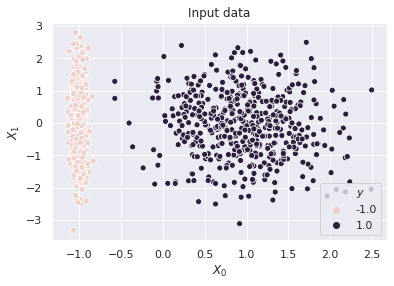

In [14]:
plot_2D_input_datapoints(X[:, :2], y)

In [15]:
y.shape

(1000, 1)

In [16]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (700, 3)
Validation dataset:  (100, 3)
Test dataset:  (200, 3)


In [17]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :2])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

Note above that 1st and 2nd column are input data features and the 3rd column effectively translates to the bias column. Adding column of ones to the input data helps in easier matrix multiplication between the input data $X$ and weights $w$.

The pseudo-code for our perceptron algorithm is as follows:

<img class="align-center" border="2" src="https://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/images/perceptron/perceptron_algo.png" width="600"/>

In [18]:
# Perceptron training algorithm
def train(X_train, Y_train, weights, learning_rate=1, total_epochs=100):

  """Training method for Perceptron.
  
  Parameters
  -----------

  X_train: ndarray (num_examples(rows) vs num_features(columns))
    Input dataset which perceptron will use to learn optimal weights
  
  Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels for input data

  weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

  learning_rate: int
    Learning rate use to learn and update weights
  
  total_epochs: int
    Max number of epochs to train the perceptron model
  """

  n_samples, _ = np.shape(X_train)
  history_weights = []
  epoch = 1

  # Number of missclassified points we would like to see in the train set.
  # While training, its value will change every epoch. If m==0, our training 
  # error will be zero.
  m = 1

  # If the most recent weights gave 0 misclassifications, break the loop.
  # Else continue until total_epochs is completed.
  while m != 0 and epoch <= total_epochs:
    m = 0

    # Compute weighted inputs and predict class labels on training set.
    weights_transpose_x = np.dot(X_train, weights)
    weights_transpose_x = signum(weights_transpose_x)
    y_train_out = np.multiply(Y_train, weights_transpose_x)
    epoch += 1
    
    # Collecting misclassified indexes and count them
    y_miscls_idxs = np.argwhere(y_train_out <= 0)[:, 0]
    y_miscls_idxs = np.unique(y_miscls_idxs)
    m = len(y_miscls_idxs)

    # Calculate gradients and update weights
    dweights = np.dot((X_train[y_miscls_idxs]).T, Y_train[y_miscls_idxs])
    weights += (learning_rate/n_samples) * dweights
    weights = np.round(weights, decimals=4)

    # Append weights to visualize decision boundary later
    history_weights.append(weights)

  if m == 0 and epoch <= total_epochs:
    print("Training has stabilized with all points classified: ", epoch)
  else:
    print(f'Training completed at {epoch-1} epochs. {m} misclassified points remain.')

  return history_weights

In [20]:
# Initializing weights to zero
_, n_features = np.shape(X_normalized_train)
_, n_outputs = np.shape(Y_train)
print(n_outputs)
weights = np.zeros((n_features, n_outputs))

1


In [22]:
print(X_normalized_train.shape,Y_train.shape,weights.shape)

(700, 3) (700, 1) (3, 1)


In [10]:
trained_weights = train(X_normalized_train, Y_train, weights, learning_rate=0.05, total_epochs=50)

Training completed at 50 epochs. 2 misclassified points remain.


Visualizing decision boundary for training set


In [11]:
generate_gifs(X_train, Y_train, trained_weights, 'train', path='content/training_decision_boundary.gif')

Gif/image generated


![perceptron_training_decision_boundary](https://drive.google.com/uc?id=1llryslKm54-7Z2i6z-TykAmNu0CNd0io)

In [12]:
best_weights = trained_weights[-1]
train_acc, _ = get_prediction(X_train, Y_train, best_weights, get_acc=True)
val_acc, _ = get_prediction(X_val, Y_val, best_weights, get_acc=True)
test_acc, _ = get_prediction(X_test, Y_test, best_weights, get_acc=True)

print("Evaluation results")
print("Training accuracy: {:.3f}" .format(train_acc))
print("Validation accuracy: {:.3f}" .format(val_acc))
print("Test accuracy: {:.3f}" .format(test_acc))

Evaluation results
Training accuracy: 99.571
Validation accuracy: 99.000
Test accuracy: 99.500


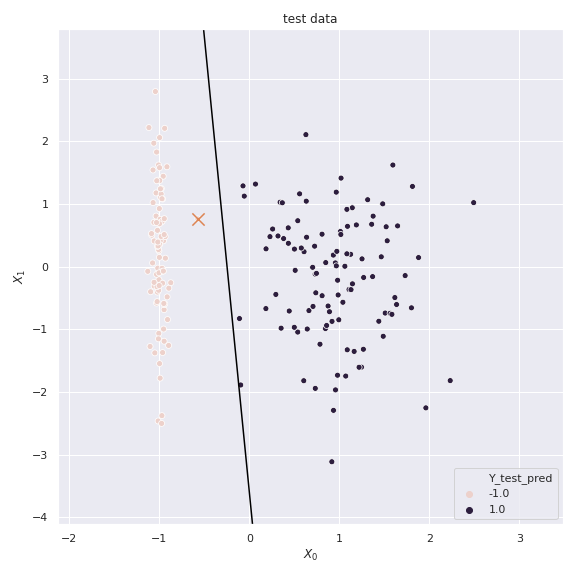

In [13]:
plot_decision_boundary(X_test, Y_test, best_weights, dataset_type='test')

## Effect of weight initialization

Previously, we had initialized our weights to zero. What would have happened if we had initialized our weights too large? Let's check that too.

In [14]:
# Initializing large weights
weights = np.ones((n_features, n_outputs)) * 3

In [15]:
trained_weights = train(X_normalized_train, Y_train, weights, learning_rate=0.05, total_epochs=1000)

Training completed at 1000 epochs. 9 misclassified points remain.


We see a similar effect. After 1000 epochs, training has still not converged. Let's see when does it converge.

In [16]:
trained_weights = train(X_normalized_train, Y_train, weights, learning_rate=0.05, total_epochs=10000)

Training completed at 10000 epochs. 4 misclassified points remain.


We shall see about better strategies of weight initializations later in the course.

## Effect of biases

Bias are additional constants attached neurons and added to the weighted input before the activation function is applied.

Let's visualize this effect of adding and removing biases in perceptron. The characteristics of biases found here is broadly applicable to other neural networks algorithms.

We know that an equation of the line can be described as such: $y = w \times x + b$. From this equation we know that intercept $b$ allows our equation to translate in our 2D plane.

W.r.t our perceptron model, we had derived a similar analogy: $Y_{prediction} = \text{signum_activation}(weights \times X_{input} + bias$).

Let us define an equation of line as follows: $0.25x - 0.85y + 3 = 0$. If we consider this line as our decision boundary, our optimal weights $=[0.25, -0.85]$ and bias $=[3]$. We will generate a random set of points on either side of line but not on it (for simplicity).

In [17]:
import numpy as np

In [18]:
# Setting the seed to ensure reproducibility of experiments
np.random.seed(10)

X = np.random.randint(-10, 10, size=(1000, 2))

# Adding column of ones to absorb bias b of the hyperplane into X
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [19]:
# our optimal weights
best_weights = np.array([[0.25], [-0.85], [3]])

In [20]:
# Method to generate random set of points on either side of line but not on it.
def get_relevant_points(X, weights):
  y_pred = np.dot(X, weights)
  y_pred[y_pred < 0] = -1
  y_pred[y_pred > 0] = 1
  relevant_idxs = np.argwhere(y_pred != 0)[:, 0]
  on_the_line_idxs = np.argwhere(y_pred == 0)[:, 0]
  return y_pred, relevant_idxs, on_the_line_idxs

In [21]:
y_pred, relevant_idxs, on_the_line_idxs = get_relevant_points(X, best_weights)

X_on_the_line = X[on_the_line_idxs]
y_on_the_line = y[on_the_line_idxs]

X = X[relevant_idxs]
y = y_pred[relevant_idxs]

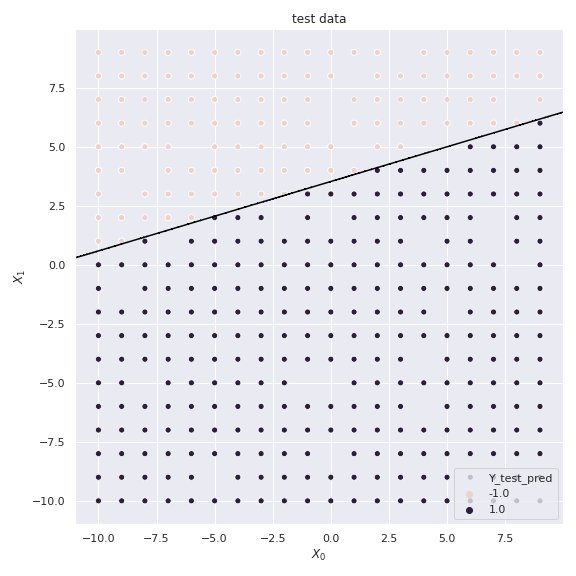

In [22]:
plot_decision_boundary(X, y, best_weights, dataset_type='test', bias='on', class_label_01_form='off', model_type='perceptron')

In [23]:
# Removing the column of ones
X = X[:, :2]
X.shape

(995, 2)

Note that after generating the samples above, we aren't appending a column of ones in $X$. Hence, when we multiply $X$ with weights $w$, we are not including the bias term.

In [24]:
# Initializing weights to zero
_, n_features = np.shape(X)
_, n_outputs = np.shape(y)

non_bias_weights = np.zeros((n_features, n_outputs))

In [25]:
non_bias_weights.shape

(2, 1)

In [26]:
# Removing bias term and training the network only with weights.
trained_weights = train(X, y, non_bias_weights, learning_rate=0.1)

Training completed at 100 epochs. 181 misclassified points remain.


In [27]:
generate_gifs(X, y, trained_weights, 'train', path='content/training_decision_boundary_with_non_bias_weights.gif', bias='off')

Gif/image generated


![non_bias_weights](https://drive.google.com/uc?id=1_uHN5z-LLj0bpPmRJBBe8Z6UKoq63DK5)

From the above gif, we can see that the decision boundary (or line equation) always passes through $0$ and is of the form: $\text{const1} \times x + \text{const2} \times y = 0$. What happens if we include the bias term while training the perceptron model? Let's see.

In [28]:
# Adding column of ones to absorb bias b of the hyperplane into X
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [29]:
# Initializing weights to zero
_, n_features = np.shape(X)
_, n_outputs = np.shape(y)

weights_with_bias = np.zeros((n_features, n_outputs))

In [30]:
weights_with_bias.shape

(3, 1)

In [31]:
# Adding bias term and training the network only with weights.
trained_weights = train(X, y, weights_with_bias, learning_rate=0.1, total_epochs=1000)

Training has stabilized with all points classified:  616


In [32]:
# Taking last 50 weights since creating gif files can take too much time
if len(trained_weights) > 100:
  last_50_trained_weights = trained_weights[len(trained_weights)-50:]

In [33]:
generate_gifs(X, y, last_50_trained_weights, 'train', path='content/training_decision_boundary_weights_with_bias.gif', bias='on')

Gif/image generated


![weights_with_bias](https://drive.google.com/uc?id=1xe0vlF_6vgwShpxcoKw7a4W324PoQVgA)

From the above gif, we can see that bias helps translate the decision boundary by representing pattern that don't necessarily pass through zero. In effect, a bias value lets you to shift the activation function by learning an appropriate threshold. One bias unit is always sufficient since it will affect each neuron differently based on its weight with each unit. Generally, to successfully learn an ML model, it almost always helpful to assign bias to every non-input since without bias, weights would have thresholds that will always be zero.

## Partially separable dataset

Let's see how the perceptron learns the decision boundary on a partially separable dataset.

In [34]:
# Initializing weights to zero
_, n_features = np.shape(X)
_, n_outputs = np.shape(y)

weights_with_bias = np.zeros((n_features, n_outputs))

In [35]:
weights_with_bias.shape, X.shape, y.shape

((3, 1), (995, 3), (995, 1))

In [36]:
# Collecting all indexes with class label = 1. Ramdomly sampling 5 indexes
# and setting class labels = -1
np.random.seed(10)
idxs_class_labels_one = np.argwhere(y == 1)[:, 0]
idxs_class_labels_one = random.sample(idxs_class_labels_one.tolist(), 5)
y[idxs_class_labels_one] = -1

In [37]:
# Adding bias term and training the network only with weights.
trained_weights = train(X, y, weights_with_bias, learning_rate=0.1, total_epochs=1000)

Training completed at 1000 epochs. 59 misclassified points remain.


In [38]:
# Taking last 50 weights since creating gif files can take too much time
if len(trained_weights) > 100:
  last_50_trained_weights = trained_weights[len(trained_weights)-50:]

In [39]:
generate_gifs(X, y, last_50_trained_weights, 'train', path='content/training_decision_boundary_partially_separable_dataset.gif')

Gif/image generated


![perceptron_partially_separable](https://drive.google.com/uc?id=1CCtJwO8ltKA_u1dcjJ71f91YHvhn6HyA)

# Perceptron learning and the XOR problem

In [40]:
# Setting the seed to ensure reproducibility of experiments
np.random.seed(10)

# Set the input data
X = np.array([[0, 0], [0, 1],
              [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = np.array([[0], [1], [1], [0]])

# Adding column of ones to absorb bias b of the hyperplane into X
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [41]:
# Initializing weights from uniform distribution
np.random.seed(312)
n_samples, n_features = np.shape(X)
_, n_outputs = np.shape(y)

limit = 1 / math.sqrt(n_features)
weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
weights[-1] = 0

In [42]:
# Train the network with the above weights
trained_weights = train(X, y, weights, learning_rate=0.1, total_epochs=50)

Training completed at 50 epochs. 2 misclassified points remain.


In [43]:
generate_gifs(X, y, trained_weights, 'train', path='content/xor_training_decision_boundary.gif')

Gif/image generated


![xor_training](https://drive.google.com/uc?id=15oVhRH7XCnb1dPf-tCypfF4G2yvuD6Gv)

By training the perceptron model for 10 epochs we can clearly see from the gif above, that at a time, atleast 2 to atmost 3 of the points are missclassified. 

This characteristic persists even if we train the perceptron model for higher number of epochs. The perceptron is unable to classify all the points correctly. Theoretically, the perceptron is unable to converge on a XOR dataset. Why do you think this is the case? The reason is because the classes in XOR are not linearly separable.